# What time are your Customers the Happiest?

## Introduction

Every business with customers would want to get feedback from customers at one point or the other, for one reason or another. Some businesses invests in marketing surveys while others do SMS surveys where they ask customer for this very needed survey. The survey is normally statistical questions with the objective of looking at what areas should the business improve on and become better.

In this current age of complex customers, a week, a month or quarterly surveys are too late because by the time you schedule a survey, most of your customers would have either:

1. Forgotten about the issue you are talking about
2. Complained until they gave up complaining and probably churned your services
3. Influenced other customers to have negative perception of your services and therefore the impact is even bigger.

The best it to do near-real-time monitoring of your customer sentiments. Automatically pick these sentiments in real-time and act-on them on the fly.

This study is called sentiment analysis and this forms the basis of this notebook.

## Objective

In this notebook i will take you through the processes of building a basic sentiment analysis classifier with step-by-step guide/explanations. I will:
1. Import all the required Libraries
2. Setup Notebook Environment Settings
3. Import the required Dataset
4. Explore the DataSet
5. Clean and Format the Data
6. Visualize the Data
7. Model
8. Evaluate
9. Test

## Workbench

In [1]:
# import the required libraries
import pandas as pd
import numpy as np

# Import the parser
from bs4 import BeautifulSoup

# Import the regular expression library
import re

# Import Natural Language Toolkit
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords

# Visualisations
import matplotlib
from wordcloud import WordCloud, STOPWORDS
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Enable logging and warnings
import logging
import warnings

# Import the IMDB Data
import imdb

# Import SKLearn Libraries
from sklearn.preprocessing import LabelBinarizer

# Timezone
import datetime
from pytz import timezone
from pytz import all_timezones

# sklearn
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize, LabelEncoder

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

# Pickle
import pickle
import dill as pickle

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rodhiambo2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rodhiambo2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [2]:
# Setting the configurations
pd.set_option('display.max_columns',100) #Displays all the columns in a dataframe
pd.set_option('display.max_colwidth',10000) #Display all the text in a dataframe column

%matplotlib inline
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
warnings.filterwarnings("ignore",category=DeprecationWarning)
sns.set()

**Import the data**

In [3]:
#importing the data into a dataframe
sentiment_data_df=pd.read_csv('data/airline_tweet_sentiments.csv',engine="python",names=["sentiment_polarity", "twitter_id","tweet_date", "query", "twitter_user","user_tweet"])

In [4]:
# Pick a small sample since all the 1.6M records are taking long to clean
sentiment_data_df = sentiment_data_df.sample(5000)

**Explore the Data**

In [5]:
# View the shape of the data
print("The dataset has {} rows and {} columns.".format(sentiment_data_df.shape[0],sentiment_data_df.shape[1]))

The dataset has 5000 rows and 6 columns.


In [6]:
# view sample records
sentiment_data_df.head()

,sentiment_polarity,twitter_id,tweet_date,query,twitter_user,user_tweet
72639,0,1694288291,Mon May 04 01:56:29 PDT 2009,NO_QUERY,EddArmitage,Doesn't look like I'll be heading to Bris'ol for photos today Maybe Weds...
802524,4,1468251092,Tue Apr 07 00:32:58 PDT 2009,NO_QUERY,lleeann,first i gotta set up some other anti spyware programs to give my dearest Spybot some company
81208,0,1752633889,Sat May 09 22:29:36 PDT 2009,NO_QUERY,chikari,The show was amazing too bad attack attack wasnt there but still sickkk.
609577,0,2223768549,Thu Jun 18 08:41:15 PDT 2009,NO_QUERY,krmsn,@tinymel96 I wore green Sunday!!!! I wish it could make a bigger difference
633334,0,2232969089,Thu Jun 18 20:38:59 PDT 2009,NO_QUERY,sonjay1126,Eating bad stuff late.


In [7]:
# view the data description
sentiment_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 72639 to 516121
Data columns (total 6 columns):
sentiment_polarity    5000 non-null int64
twitter_id            5000 non-null int64
tweet_date            5000 non-null object
query                 5000 non-null object
twitter_user          5000 non-null object
user_tweet            5000 non-null object
dtypes: int64(2), object(4)
memory usage: 273.4+ KB


**Notes**

1. Change the twitter_date column to a specific format
2. Pick only the required columns
3. The target variable is sentiment_polarity with 0=negative,2=neutral,4=positive

In [8]:
def format_datetime(date_string):
    #Split the string
    date_array = date_string.split("PDT")
    date_index = date_array[0]
    date_year  = date_array[1]
    
    # Concatenate the date
    date = date_index+date_year
    
    # Format the date
    formatted_date = datetime.datetime.strptime(date, '%a %b %d %X %Y').strftime('%Y-%m-%d %H:%M:%S')
    return formatted_date

In [9]:
def extract_date(date_time_string):
    #Split the string
    date_array = date_time_string.split(" ")
    date_index = date_array[0]    
    return date_index

In [10]:
def extract_time(date_time_string):
    #Split the string
    date_array = date_time_string.split(" ")
    time_index  = date_array[1]
    return time_index

In [11]:
# Create a tweet_date_time column to be of type datetime
sentiment_data_df["tweet_date_time"] = sentiment_data_df["tweet_date"].apply(format_datetime)
sentiment_data_df["tweet_day"] = sentiment_data_df["tweet_date_time"].apply(extract_date)
sentiment_data_df["tweet_time"] = sentiment_data_df["tweet_date_time"].apply(extract_time)

In [12]:
# check if the date has been created
sentiment_data_df.sample(2)

,sentiment_polarity,twitter_id,tweet_date,query,twitter_user,user_tweet,tweet_date_time,tweet_day,tweet_time
641691,0,2235308353,Fri Jun 19 00:54:39 PDT 2009,NO_QUERY,khanzaporiska,"Brb,choir practice,fuuu bad feeling",2009-06-19 00:54:39,2009-06-19,00:54:39
465158,0,2175285565,Mon Jun 15 00:34:17 PDT 2009,NO_QUERY,MattAlexander86,can't sleep I think I'm gonna pull an all-nighter and get to bed early tonight to fix my screwed up sleeping schedule.,2009-06-15 00:34:17,2009-06-15,00:34:17


In [13]:
# select the columns you are interested in
sentiment_data_df = sentiment_data_df[["tweet_date_time","tweet_day","tweet_time","user_tweet","sentiment_polarity"]]
sentiment_data_df.sample(2)

,tweet_date_time,tweet_day,tweet_time,user_tweet,sentiment_polarity
1420171,2009-06-06 14:15:27,2009-06-06,14:15:27,@anijones you aren't alone i'm here,4
325775,2009-06-02 13:02:37,2009-06-02,13:02:37,I most likely failed my final in math. my parents are going to shoot me,0


In [14]:
# Change the tweeter datetime to datetime
sentiment_data_df["tweet_date_time"] = pd.to_datetime(sentiment_data_df["tweet_date_time"], format="%Y-%m-%d %H:%M:%S")
sentiment_data_df["tweet_day"] = pd.to_datetime(sentiment_data_df["tweet_day"], format="%Y-%m-%d")
sentiment_data_df["tweet_time"] = pd.to_timedelta(sentiment_data_df["tweet_time"])
sentiment_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 72639 to 516121
Data columns (total 5 columns):
tweet_date_time       5000 non-null datetime64[ns]
tweet_day             5000 non-null datetime64[ns]
tweet_time            5000 non-null timedelta64[ns]
user_tweet            5000 non-null object
sentiment_polarity    5000 non-null int64
dtypes: datetime64[ns](2), int64(1), object(1), timedelta64[ns](1)
memory usage: 234.4+ KB


In [15]:
# Check the distribution of the target variable to see if it is balanced
sentiment_data_df["sentiment_polarity"].value_counts()

0    2521
4    2479
Name: sentiment_polarity, dtype: int64

In [16]:
# Create the positive dataframe
positive_sentiments_df = sentiment_data_df[sentiment_data_df["sentiment_polarity"] == 4]
positive_sentiments_df.sample(2)

,tweet_date_time,tweet_day,tweet_time,user_tweet,sentiment_polarity
898048,2009-05-03 22:46:57,2009-05-03,22:46:57,"@WinterDaisy And that'll probably be me tonight, too.....good night",4
1323192,2009-06-03 02:58:52,2009-06-03,02:58:52,"Bye bye Hazel... could we get more good news with GB going too? Sun, Pimms and a new PM?",4


In [17]:
# Create the negative dataframe
negative_sentiments_df = sentiment_data_df[sentiment_data_df["sentiment_polarity"] == 0]
negative_sentiments_df.sample(2)

,tweet_date_time,tweet_day,tweet_time,user_tweet,sentiment_polarity
192526,2009-05-30 01:33:17,2009-05-30,01:33:17,@lejunkdrawer It's unfortunate that Marcy Walker has retired from acting. Well. For us. Not for her. http://bit.ly/oQG93,0
433592,2009-06-07 07:39:38,2009-06-07,07:39:38,Sims 3 is stressing me out! it worked fine on Friday! Now its just being a little shit.,0


In [18]:
# Check the trending of positive polarity by datetime
positive_polarity_vc = positive_sentiments_df["tweet_day"].value_counts()
positive_polarity_df = positive_polarity_vc.rename_axis('date').reset_index(name='counts') # Convert the value count to a dataframe
positive_polarity_df = positive_polarity_df.sort_values(by=["date"])
positive_polarity_df.head()

,date,counts
33,2009-04-06,8
21,2009-04-07,34
34,2009-04-17,6
18,2009-04-18,35
16,2009-04-19,51


In [19]:
# Check the trending of negative polarity by datetime
negative_polarity_vc = negative_sentiments_df["tweet_day"].value_counts()
negative_polarity_df = negative_polarity_vc.rename_axis('date').reset_index(name='counts') # Convert the value count to a dataframe
negative_polarity_df = negative_polarity_df.sort_values(by=["date"])
negative_polarity_df.head()

,date,counts
43,2009-04-06,4
27,2009-04-07,22
42,2009-04-17,4
28,2009-04-18,21
21,2009-04-19,40


**Data Cleaning**

In [20]:
# Helper Method to perform the data cleaning
def cleaning(raw_review):
    import nltk
    
    # 1. Remove HTML.
    html_text = BeautifulSoup(raw_review,"html.parser").get_text()
    
    # 2. Remove non-letters.
    letters = re.sub("[^a-zA-Z]", " ", html_text)
    
    # 3. Convert to lower case.
    letters = letters.lower()
    
    # 4. Tokenize.
    tokens = nltk.word_tokenize(letters)
    
    # 5. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 6. Remove stop words. 
    words = [w for w in tokens if not w in stops]
    
    # 7. Stemming
    words = [nltk.stem.SnowballStemmer('english').stem(w) for w in words]
    
    # 8. Join the words back into one string separated by space, and return the result.
    return " ".join(words)

In [21]:
# Apply the cleaning to the user tweet
sentiment_data_df["cleaned_user_tweet"] = sentiment_data_df["user_tweet"].apply(cleaning)
sentiment_data_df.sample(5)

,tweet_date_time,tweet_day,tweet_time,user_tweet,sentiment_polarity,cleaned_user_tweet
1161321,2009-05-31 03:18:24,2009-05-31,03:18:24,Had a blast last night at the Birthday Party now getting ready for Sundays @ Muschi!!!,4,blast last night birthday parti get readi sunday muschi
1573449,2009-06-15 23:13:53,2009-06-15,23:13:53,Morning Twitter,4,morn twitter
1021550,2009-05-22 07:09:32,2009-05-22,07:09:32,@alydenisof Clever use of time zones! Just need to add a #FollowFriday hashtag to your tweet to make it perfect!,4,alydenisof clever use time zone need add followfriday hashtag tweet make perfect
204402,2009-05-30 09:32:47,2009-05-30,09:32:47,Ugh I so don't want to go to work today,0,ugh want go work today
481799,2009-06-15 09:35:06,2009-06-15,09:35:06,"Watching live feed of parade, cringing thinking about trying to get to AIP to work on finals. Love ya pens, but you have awful timing.",0,watch live feed parad cring think tri get aip work final love ya pen aw time


**Visualization**

E:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


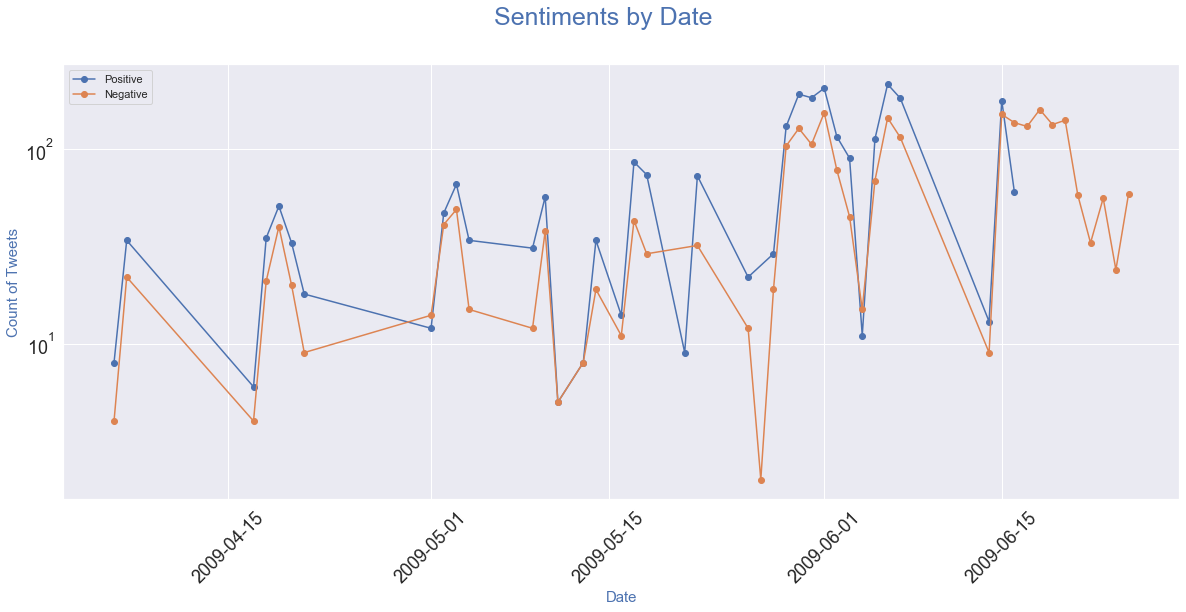

In [22]:
# Draw a trend of polarity over time
#Create the fig
fig = plt.figure(figsize=(20,8))

positive_dates = matplotlib.dates.date2num(positive_polarity_df["date"])
negative_dates = matplotlib.dates.date2num(negative_polarity_df["date"])

plt.ylabel("Count of Tweets", fontsize=15, color='b')
plt.yscale("log")
plt.xlabel("Date", fontsize=15, color='b')
plt.suptitle('Sentiments by Date', fontsize=25, color='b');
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=18)

plt.plot_date(positive_dates, positive_polarity_df["counts"],ls="-", label="Positive")
plt.plot_date(negative_dates, negative_polarity_df["counts"],ls="-", label="Negative")

plt.legend(loc="upper left")

**Word Cloud**

In [23]:
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

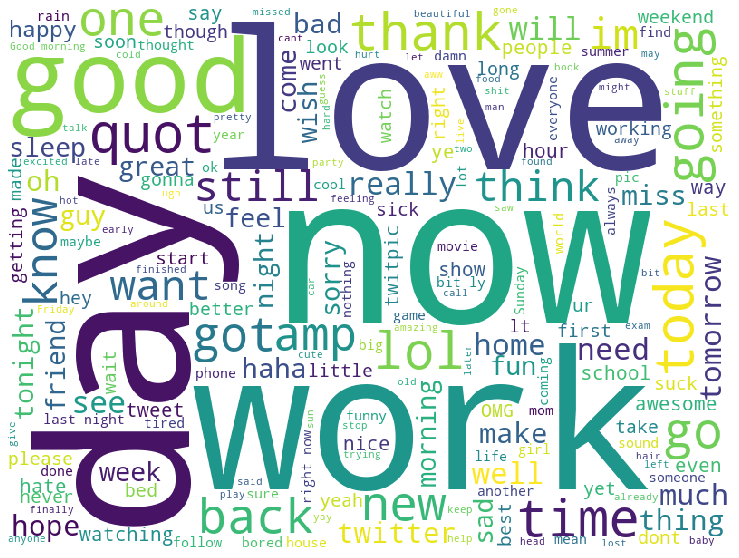

In [24]:
cloud(' '.join(sentiment_data_df['user_tweet']))

**Distribution**

In [25]:
# Add new columns for the the word frequencies and unique word frequencies
sentiment_data_df['freq_word'] = sentiment_data_df['cleaned_user_tweet'].apply(lambda x: len(str(x).split()))
sentiment_data_df['unique_freq_word'] = sentiment_data_df['cleaned_user_tweet'].apply(lambda x: len(set(str(x).split())))

In [26]:
# replace the target variables with text
sentiment_data_df["sentiment_polarity"] = sentiment_data_df["sentiment_polarity"].replace(0,"negative")
sentiment_data_df["sentiment_polarity"] = sentiment_data_df["sentiment_polarity"].replace(4,"positive")

In [27]:
# Display sample dataframe with the word frequencies
sentiment_data_df.sample(5)

,tweet_date_time,tweet_day,tweet_time,user_tweet,sentiment_polarity,cleaned_user_tweet,freq_word,unique_freq_word
1183263,2009-05-31 11:07:48,2009-05-31,11:07:48,"my MBP babe, itÂ´s mine",positive,mbp babe mine,3,3
977998,2009-05-18 00:28:37,2009-05-18,00:28:37,i love my wife,positive,love wife,2,2
654847,2009-06-19 08:48:07,2009-06-19,08:48:07,OMG!!! I'm finally finish with my exams..like forever...WOW!!haha..I'm excited..just hope I don't have to go for a function tonight,negative,omg final finish exam like forev wow haha excit hope go function tonight,13,13
474733,2009-06-15 06:03:08,2009-06-15,06:03:08,snip snip snip and my hair's significantly shorter,negative,snip snip snip hair signific shorter,6,4
1319889,2009-06-03 01:49:56,2009-06-03,01:49:56,"@bakushori personal lifehacker, eh? sounds like fun! No worries and enjoy the search experience.",positive,bakushori person lifehack eh sound like fun worri enjoy search experi,11,11


median of word frequency:  7.0
median of unique word frequency:  7.0


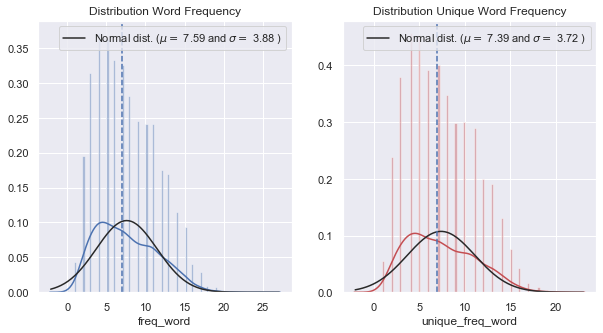

In [28]:
# Draw the word distribution
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(10,5)

sns.distplot(sentiment_data_df['freq_word'], bins = 90, ax=axes[0], fit = stats.norm)
(mu0, sigma0) = stats.norm.fit(sentiment_data_df['freq_word'])
axes[0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu0, sigma0)],loc='best')
axes[0].set_title("Distribution Word Frequency")
axes[0].axvline(sentiment_data_df['freq_word'].median(), linestyle='dashed')
print("median of word frequency: ", sentiment_data_df['freq_word'].median())


sns.distplot(sentiment_data_df['unique_freq_word'], bins = 90, ax=axes[1], color = 'r', fit = stats.norm)
(mu1, sigma1) = stats.norm.fit(sentiment_data_df['unique_freq_word'])
axes[1].set_title("Distribution Unique Word Frequency")
axes[1].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu1, sigma1)],loc='best')
axes[1].axvline(sentiment_data_df['unique_freq_word'].median(), linestyle='dashed')
print("median of unique word frequency: ", sentiment_data_df['unique_freq_word'].median())

**Logistic Regression**

In [29]:
tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
lr = LogisticRegression(C=0.1,  
                           max_iter=20, 
                           fit_intercept=True, 
                           n_jobs=3, 
                           solver='liblinear',
                           class_weight='balanced')

In [35]:
# Helper Class for Training
def lr_cv(splits, X, Y, pipeline, average_method, sample_method):
    
    #Grid Search
    parameters = {
              
              }

    grid = GridSearchCV(pipeline, parameters, cv=2, verbose=1)
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    
    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    for train, test in kfold.split(X, Y):
        #lr_fit = pipeline.fit(X[train], Y[train])
        lr_fit = grid.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        
        print('              Positive    Negative  ')
        print('precision:',precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        print('-'*50)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))
    
    # Create the pickle file
    #joblib.dump(grid.best_estimator_, '{}_smsiq_sentiment_analysis_logistic_regression_model.pkl'.format(sample_method), compress = 1)
    joblib.dump(grid.best_estimator_, 'models/{}_sentiment_lg_model_v3.pkl'.format(sample_method))
    #pkl_filename = "{}_smsiq_message_category_lg_model.pkl".format(sample_method)  
    #with open(pkl_filename, 'wb') as file:  
    #    pickle.dump(grid, file)

In [38]:
# Define the pipeline
original_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', lr)
])

**Train the data**

In [37]:
lr_cv(5, sentiment_data_df['cleaned_user_tweet'], sentiment_data_df['sentiment_polarity'], original_pipeline, 'macro','balanced')

Fitting 2 folds for each of 1 candidates, totalling 2 fits


E:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: np.nan is an invalid document, expected byte or unicode string.

**Test the model**

In [45]:
# Test the smote model
model = 'models/balanced_sentiment_lg_model_v3.pkl'

with open(model ,'rb') as f:
    sentiment_model = joblib.load(f)
    
    message = ["What is really wrong with you?"]
    
    pred_sentiment = sentiment_model.predict(message)[0]
    
    sentiment_probability = sentiment_model.predict_proba(message)[0]
    positive_probability = sentiment_probability[0]
    negative_probability = sentiment_probability[1]
    
    print("Positive Probability : {}".format(positive_probability*100))
    print("Negative Probability : {}".format(negative_probability*100))

FileNotFoundError: [Errno 2] No such file or directory: 'models/balanced_sentiment_lg_model_v3.pkl'